In [ ]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loading the data

In [ ]:
material_intensity = pd.read_csv('material_intensity.csv',decimal=',')

In [ ]:
material_intensity.rename(columns = {'year assumed for data collection':'year','Material Intensity (ton/GW)':'m_intensity'},inplace=True)

In [ ]:
# Data

# MATERIAL INTENSITY
wind_intensity = material_intensity[material_intensity['Tech']=='Wind'].copy()
wind_intensity= wind_intensity.replace({'classification':{'EESG':'DD-EESG','GB-DFIG':'DFIG'}}) #Turbines defined as EESG are assumed to have a Direct Drive,
                                                                                               #Turbines defined as GB-DFIG are classified just as DFIG

solar_intensity = material_intensity[material_intensity['Tech']=='Solar'].copy()
solar_intensity= solar_intensity.replace({'classification':{'PERC':'advanced_c-Si','SHJ':'advanced_c-Si'}}) #PERC solar tech is classified as advanced_c-Si
                                                                                                  #SHJ solar tech is classified as advanced_c-Si

# MARKETSHARE
market_share_wind = pd.read_csv('market_share_wind.csv',decimal=',')
market_share_solar = pd.read_csv('market_share_solar.csv')

#NAMEPLATE_CAPACITY
nameplate_capacity = pd.read_csv('nameplate_capacity.csv')
nameplate_capacity['capacity_GW'] = nameplate_capacity['nameplate_capacity']*1000 #change units to TW

# WIND POWER

## Data preprocessing

In [ ]:
wind_intensity.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
0,Wind,Chromium,probably all,470.0,"(Chen Li, 2022)",SDD,2022,literature,NaN,NaN
1,Wind,Dysprosium,probably all,12.0,"(Chen Li, 2022)",SDD,2022,literature,NaN,NaN
2,Wind,Manganese,probably all,780.0,"(Chen Li, 2022)",SDD,2022,literature,NaN,NaN
3,Wind,Molybdenum,probably all,99.0,"(Chen Li, 2022)",SDD,2022,literature,NaN,NaN
4,Wind,Neodymium,probably all,28.0,"(Chen Li, 2022)",SDD,2022,literature,NaN,NaN


In [ ]:
#HS_PMSG and MS_PMSG correspond to GB types, and in this case the % for HS are 0, MS is assumed to be GB, to match it with mean intensity wind df
market_share_wind['classification'].replace('MS-PMSG','GB-PMSG',inplace=True)
market_share_wind.drop(4, inplace=True)
print(market_share_wind)

  classification  onshore  offshore
0            SDD     0.00      0.00
1            PDD     0.00      0.00
2        DD-EESG     0.30      0.00
3           SCIG     0.26      0.00
5        DD-PMSG     0.08      0.54
6           DFIG     0.36      0.17
7        GB-PMSG     0.00      0.28


In [ ]:
#DataFrames for each of the turbine Type category
onshore_df = wind_intensity[wind_intensity['Type']=='onshore'].copy()
offshore_df = wind_intensity[wind_intensity['Type']=='offshore'].copy()
all_df = pd.concat([wind_intensity[wind_intensity['Type']=='All'],wind_intensity[wind_intensity['Type']=='probably all']]).copy()

In [ ]:
# Since there is no criteria to define the type (onshore/offshore) of the all_df, that data will be added to both onshore and offshore df
onshore_df = pd.concat([onshore_df,all_df])
offshore_df = pd.concat([offshore_df,all_df])

In [ ]:
onshore_df.classification.value_counts(dropna=False)

DD-PMSG    71
NaN        55
DD-EESG    54
GB-PMSG    37
DFIG       26
SDD         9
PDD         9
SCIG        5
Name: classification, dtype: int64

In [ ]:
# NULL DATA HANDLING
# Randomly assigned classification types for rows with no classification defined considering the type of turbine used for offshore and onshore
import random

#Selection of null values for both dfs
na_onshore_df = onshore_df[onshore_df['classification'].isnull()].copy()
na_offshore_df = offshore_df[offshore_df['classification'].isnull()].copy()

#Create series of random classification for empty spaces
na_onshore_series = na_onshore_df['classification'].apply(lambda x: random.choice(['DD-PMSG', 'GB-PMSG','DD-EESG','DFIG','SDD','PDD','SCIG'])).copy()
na_offshore_series = na_offshore_df['classification'].apply(lambda x: random.choice(['DD-PMSG', 'GB-PMSG','DFIG','SDD','PDD']))

#fill null values with the series created
onshore_df['classification'].fillna(na_onshore_series,inplace=True)
offshore_df['classification'].fillna(na_offshore_series,inplace=True)

In [ ]:
onshore_df.replace({'Type':{'All':'onshore','probably all':'onshore'}},inplace=True)
offshore_df.replace({'Type':{'All':'offshore','probably all':'offshore'}},inplace=True)

In [ ]:
#Create complete dataframe with out null values
wind_int_total = pd.concat([onshore_df,offshore_df])

In [ ]:
wind_int_total.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
9,Wind,Chromium,onshore,470.0,"(Chen Li, 2022)",SCIG,2022,literature,NaN,Assumed to be onshore according to wind share ...
10,Wind,Manganese,onshore,780.0,"(Chen Li, 2022)",SCIG,2022,literature,NaN,Assumed to be onshore according to wind share ...
11,Wind,Molybdenum,onshore,99.0,"(Chen Li, 2022)",SCIG,2022,literature,NaN,Assumed to be onshore according to wind share ...
12,Wind,Nickel,onshore,430.0,"(Chen Li, 2022)",SCIG,2022,literature,NaN,Assumed to be onshore according to wind share ...
13,Wind,Zinc,onshore,5500.0,"(Chen Li, 2022)",SCIG,2022,literature,NaN,Assumed to be onshore according to wind share ...


## Exploring the data

In [ ]:
wind_int_total['Material'].value_counts()

Iron            100
Copper           64
Neodymium        55
Aluminium        54
Dysprosium       53
Nickel           28
Molybdenum       26
Chromium         25
Manganese        24
Praseodymium     20
Terbium          19
Boron            15
Zinc             13
Vanadium          2
Niobium           2
Tin               2
Yttrium           2
Silicon           1
Lead              1
Name: Material, dtype: int64

In [ ]:
# DF for each Material for Wind Power
aluminium_w = wind_int_total[wind_int_total['Material'] == 'Aluminium']
copper_w = wind_int_total[wind_int_total['Material'] == 'Copper']
iron_w = wind_int_total[wind_int_total['Material'] == 'Iron']
neodymium_w = wind_int_total[wind_int_total['Material'] == 'Neodymium']
dysprosium_w = wind_int_total[wind_int_total['Material'] == 'Dysprosium']
chromium_w = wind_int_total[wind_int_total['Material'] == 'Chromium']
nickel_w = wind_int_total[wind_int_total['Material'] == 'Nickel']
molybdenum_w = wind_int_total[wind_int_total['Material'] == 'Molybdenum']
manganese_w = wind_int_total[wind_int_total['Material'] == 'Manganese']
praseodymium_w = wind_int_total[wind_int_total['Material'] == 'Praseodymium']
terbium_w = wind_int_total[wind_int_total['Material'] == 'Terbium']
boron_w = wind_int_total[wind_int_total['Material'] == 'Boron']
zinc_w = wind_int_total[wind_int_total['Material'] == 'Zinc']
vanadium_w = wind_int_total[wind_int_total['Material'] == 'Vanadium']
lead_w = wind_int_total[wind_int_total['Material'] == 'Lead']
niobium_w = wind_int_total[wind_int_total['Material'] == 'Niobium']
silicon_w = wind_int_total[wind_int_total['Material'] == 'Silicon']
tin_w = wind_int_total[wind_int_total['Material'] == 'Tin']
yttrium_w = wind_int_total[wind_int_total['Material'] == 'Yttrium']

In [ ]:
iron_w.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
48,Wind,Iron,onshore,17600.0,"(Elsam Engineering, 2004; Ghenai, 2012)",PDD,2004,manufacturer,NaN,"- Qty for 2 MW wind turbine in (Wang, 2019)\n-..."
49,Wind,Iron,onshore,104370.0,"(Elsam Engineering, 2004; Ghenai, 2012)",SCIG,2004,manufacturer,NaN,"- Qty for 2 MW wind turbine in (Wang, 2019)\n-..."
73,Wind,Iron,onshore,147000.0,"(Ashby, 2013)",DFIG,2013,literature,"Watari, 2019",Steel. Considered to be 98% Iron
75,Wind,Iron,onshore,96040.0,"(Guezuraga et al., 2012)",SCIG,2012,manufacturer,"Watari, 2019",Steel. Considered to be 98% Iron
76,Wind,Iron,onshore,145040.0,"(Guezuraga et al., 2012)",DD-PMSG,2012,manufacturer,"Watari, 2019",Steel. Considered to be 98% Iron


In [ ]:
def material_wind_plot(material):
  sns.boxplot(data=material,
              x='Material',
              y="m_intensity",
              hue="Data Source",
              hue_order=['literature','manufacturer'],
              dodge=True,   # separate boxes of different colors
              width=0.7,    # width of boxes
              whis=1.5,     # controls the length of whiskers of a box
              palette = "deep"
        )
  plt.title("Material intensity by Data Source")
  plt.show()

  sns.boxplot(data=material,
              x="Material",
              y="m_intensity",
              hue="Type",
              hue_order=['onshore','offshore'],
              dodge=True,   # separate boxes of different colors
              width=0.7,    # width of boxes
              whis=1.5,     # controls the length of whiskers of a box
              palette = "deep"
        )

  # plt.title("Material intensity by type of turbine")
  # plt.show()

  # See relation between material intensity ad year of data collection for COPPER
  g = sns.pairplot(material,
                  hue='Data Source',
                  hue_order=['literature','manufacturer'],
                  diag_kind="hist")
  plt.show()


  #Show
  g = sns.scatterplot(material, x='classification',y='m_intensity',
                  hue='Type',
      )
  plt.show()

  print(material['m_intensity'].mean())
  print(material['m_intensity'].median())

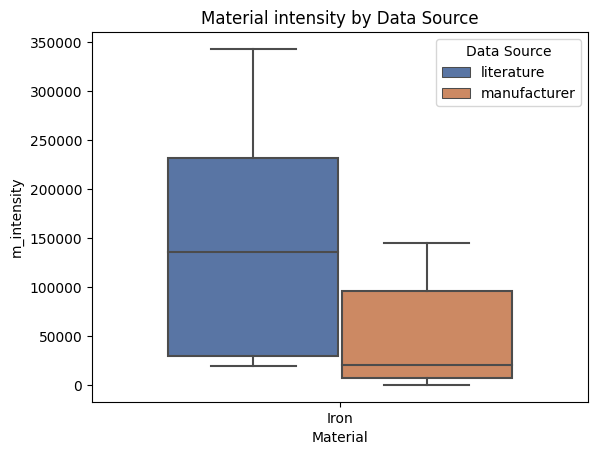

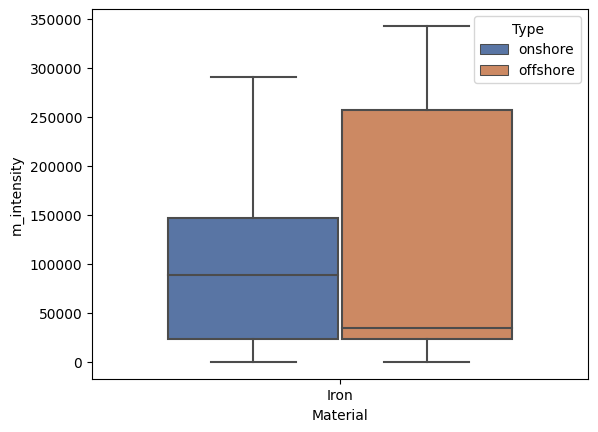

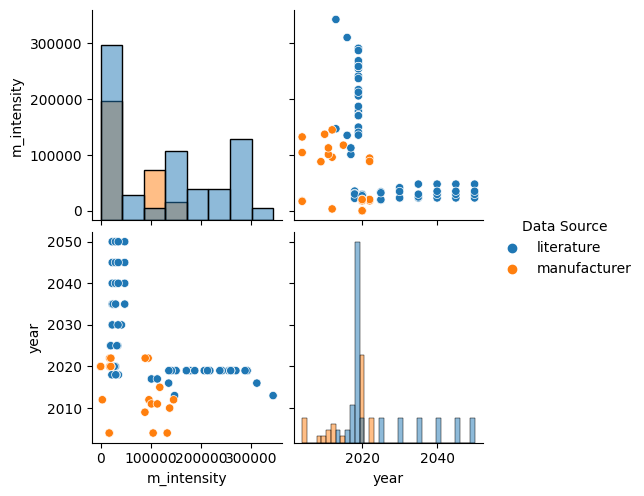

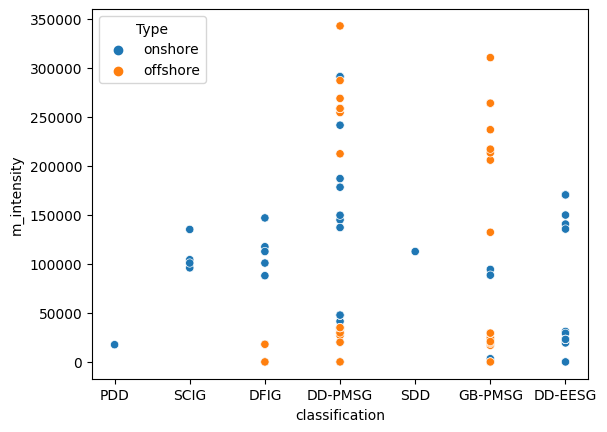

107047.86
47800.0


In [ ]:
material_wind_plot(iron_w)

In [ ]:
#material_wind_plot(dysprosium_w)

In [ ]:
#material_wind_plot(chromium)

# SOLAR POWER

## Data preprocessing

In [ ]:
solar_intensity.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
411,Solar,Copper,NaN,300.0,"(Ashby, 2013)",c-Si,2013,literature,"Watari, 2019",NaN
412,Solar,Copper,NaN,825.0,"(Fizaine and Court, 2015)",c-Si,2015,literature,"Watari, 2019",NaN
413,Solar,Copper,NaN,250.0,"(Mclellan et al., 2016)",c-Si,2016,literature,"Watari, 2019",NaN
414,Solar,Lead,NaN,6.0,"(Fizaine and Court, 2015)",c-Si,2015,literature,"Watari, 2019",NaN
415,Solar,Lead,NaN,72.0,"(World Bank Group, 2017)",c-Si,2017,literature,"Watari, 2019",NaN


In [ ]:
#Null values in 'classification' are filled randomly
import random

#Selection of null values for solar dataset
na_solar_df = solar_intensity[solar_intensity['classification'].isnull()].copy()

#Create series of random classification for empty spaces
na_solar_series = na_solar_df['classification'].apply(lambda x: random.choice(['c-Si','CIGS','CdTe','advanced_c-Si','III-V']))

#fill null values with the series created
solar_intensity['classification'].fillna(na_solar_series,inplace=True)

In [ ]:
#DataFrames for each of the solar type category. Data points without Type defined are added in both datasets
roof_df = pd.concat([ solar_intensity[solar_intensity['Type']=='roof_mounted'],solar_intensity[solar_intensity['Type'].isnull()] ])
ground_df = pd.concat([ solar_intensity[solar_intensity['Type']=='open_field'],solar_intensity[solar_intensity['Type'].isnull()] ])

#fill null Type with each category
roof_df['Type'].fillna('roof_mounted',inplace=True)
ground_df['Type'].fillna('open_field',inplace=True)

#Create complete dataframe with out null values
solar_int_total = pd.concat([roof_df,ground_df])

In [ ]:
solar_int_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 761 to 1141
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tech              905 non-null    object 
 1   Material          905 non-null    object 
 2   Type              905 non-null    object 
 3   m_intensity       905 non-null    float64
 4   Reference         905 non-null    object 
 5   classification    905 non-null    object 
 6   year              905 non-null    int64  
 7   Data Source       373 non-null    object 
 8   Principal Source  373 non-null    object 
 9   Notes             58 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 77.8+ KB


In [ ]:
solar_int_total.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
761,Solar,Aluminium,roof_mounted,13452.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN
762,Solar,Copper,roof_mounted,1451.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN
763,Solar,Indium,roof_mounted,111.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN
764,Solar,Gallium,roof_mounted,26.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN
765,Solar,Selenium,roof_mounted,248.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN


## Exploring the data

In [ ]:
# DF for each Material for Solar Power
indium_s = solar_intensity[solar_intensity['Material'] == 'Indium']
copper_s = solar_intensity[solar_intensity['Material'] == 'Copper']
aluminium_s = solar_intensity[solar_intensity['Material'] == 'Aluminium']
tin_s = solar_intensity[solar_intensity['Material'] == 'Tin']
silver_s = solar_intensity[solar_intensity['Material'] == 'Silver']
silicon_s = solar_intensity[solar_intensity['Material'] == 'Silicon']
gallium_s = solar_intensity[solar_intensity['Material'] == 'Gallium']

In [ ]:
aluminium_s.head()

,Tech,Material,Type,m_intensity,Reference,classification,year,Data Source,Principal Source,Notes
495,Solar,Aluminium,open_field,12876.0,"(Gervais et al,, 2021)",CIGS,2018,NaN,NaN,NaN
504,Solar,Aluminium,open_field,12537.0,"(Gervais et al,, 2021)",CIGS,2020,NaN,NaN,NaN
513,Solar,Aluminium,open_field,11848.0,"(Gervais et al,, 2021)",CIGS,2025,NaN,NaN,NaN
522,Solar,Aluminium,open_field,805.0,"(Gervais et al,, 2021)",CIGS,2030,NaN,NaN,NaN
531,Solar,Aluminium,open_field,791.0,"(Gervais et al,, 2021)",CIGS,2035,NaN,NaN,NaN


In [ ]:
def material_solar_plot(material):
  g = sns.boxplot(data=material,
              x='Material',
              y="m_intensity",
              hue="classification",
              dodge=True,   # separate boxes of different colors
              width=0.7,    # width of boxes
              whis=1.5,     # controls the length of whiskers of a box
              palette = "deep"
        )
  sns.move_legend(g, "lower center",bbox_to_anchor=(0.5, -0.4), ncol=5, title='Group', frameon=False,)
  plt.title("Material intensity")
  plt.show()

  # See relation between material intensity ad year of data collection for COPPER
  g = sns.pairplot(material,
                  vars=['m_intensity','year'],
                  hue='Type',
                  diag_kind="hist")
  plt.show()

  print(material['m_intensity'].mean())
  print(material['m_intensity'].median())

In [ ]:
#material_solar_plot(gallium_s)

In [ ]:
#material_solar_plot(copper_s)

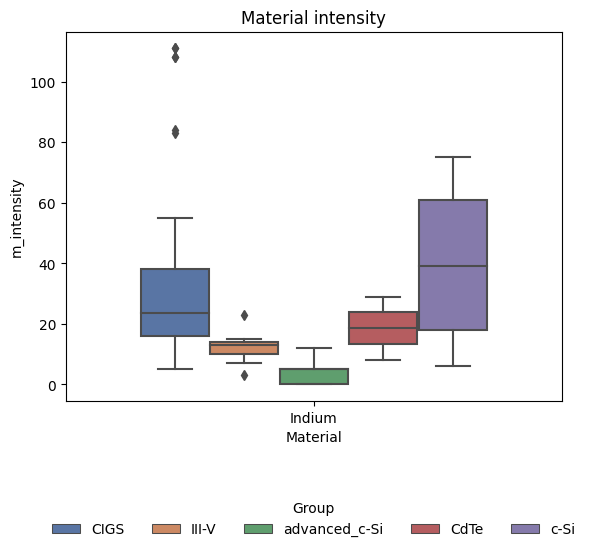

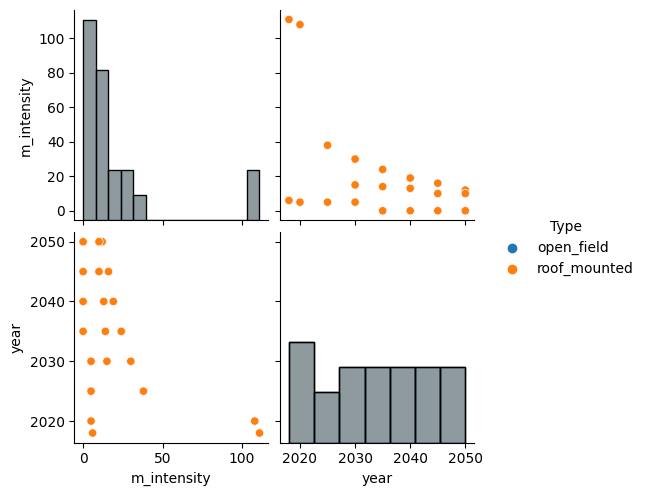

23.716216216216218
14.5


In [ ]:
material_solar_plot(indium_s)

# Energy Matrix building

In [ ]:
# Average material intensity per type of classification and material for wind power data
mean_int_wind = pd.DataFrame(onshore_df.groupby(['classification','Material'])['m_intensity'].mean())
mean_int_wind.rename(columns = {'m_intensity':'m_int_onshore'},inplace=True)
mean_int_wind = mean_int_wind.assign(m_int_offshore = offshore_df.groupby(['classification','Material'])['m_intensity'].mean()).reset_index()
mean_int_wind.head()

,classification,Material,m_int_onshore,m_int_offshore
0,DD-EESG,Aluminium,18729.000000,NaN
1,DD-EESG,Boron,0.000000,NaN
2,DD-EESG,Chromium,469.666667,NaN
3,DD-EESG,Copper,19011.200000,NaN
4,DD-EESG,Dysprosium,6.000000,NaN


In [ ]:
# Average material intensity per type of classification and material for solar power data
mean_int_solar = pd.DataFrame(roof_df.groupby(['classification','Material'])['m_intensity'].mean())
mean_int_solar.rename(columns = {'m_intensity':'m_int_roof'},inplace=True)
mean_int_solar = mean_int_solar.assign(m_int_ground = ground_df.groupby(['classification','Material'])['m_intensity'].mean()).reset_index()
mean_int_solar.head()

,classification,Material,m_int_roof,m_int_ground
0,CIGS,Aluminium,5129.333333,11129.111111
1,CIGS,Boron,0.001000,NaN
2,CIGS,Cadmium,15.000000,15.000000
3,CIGS,Copper,1075.900000,1904.727273
4,CIGS,Gallium,15.863636,15.863636


In [ ]:
def intensities(element):
    #Subset for wind weighted mean intensity
    subset1 = mean_int_wind[mean_int_wind['Material'] == element]
    #subset for mean and median intensity onshore
    subset2 = onshore_df[onshore_df['Material'] == element]
    #subset for mean and median intensity offshore
    subset3 = offshore_df[offshore_df['Material'] == element]

    #subset for solar weighted mean intensity
    subset4 = mean_int_solar[mean_int_solar['Material'] == element]
    #subset for mean and median intensity roof mounted
    subset5 = roof_df[roof_df['Material'] == element]
    #subset for mean and median intensity open field
    subset6 = ground_df[ground_df['Material'] == element]

    # #subset for mean and median intensity total solar
    # subset5 = solar_int_total[solar_int_total['Material'] == element]


    # merge of subset 1 with market shares data for wind
    wind_market_sub=subset1.merge(market_share_wind,on='classification')
    m_int_onshore = (wind_market_sub['m_int_onshore']*wind_market_sub['onshore']).sum()
    m_int_offshore = (wind_market_sub['m_int_offshore']*wind_market_sub['offshore']).sum()
    #mean_onshore = subset2['m_intensity'].mean()
    #median_onshore = subset2['m_intensity'].median()
    #mean_offshore = subset3['m_intensity'].mean()
    #median_offshore = subset3['m_intensity'].median()

    # merge of subset 4 with market shares data for solar
    solar_market_sub=subset4.merge(market_share_solar,on='classification')
    m_int_roof = (solar_market_sub['m_int_roof']*solar_market_sub['market_share_norm']).sum()
    m_int_ground = (solar_market_sub['m_int_ground']*solar_market_sub['market_share_norm']).sum()
    #mean_roof = subset5['m_intensity'].mean()
    #median_roof = subset5['m_intensity'].median()
    #mean_ground = subset6['m_intensity'].mean()
    #median_ground = subset6['m_intensity'].median()

    #return m_int_onshore,mean_onshore,median_onshore, m_int_offshore, mean_offshore,median_offshore, m_int_roof, mean_roof, median_roof, m_int_ground, mean_ground, median_ground
    return m_int_onshore, m_int_offshore, m_int_roof, m_int_ground

In [ ]:
market_share_solar.head()

,classification,market share,market_share_norm
0,c-Si,44.8,0.493392
1,CIGS,6.4,0.070485
2,CdTe,4.7,0.051762
3,advanced_c-Si,25.6,0.281938
4,III-V,9.3,0.102423


In [ ]:
elements_wind = mean_int_wind['Material'].copy().drop_duplicates()
elements_solar = mean_int_solar['Material'].copy().drop_duplicates()
elements = pd.concat([elements_wind,elements_solar]).drop_duplicates().to_list()

m_intensity_df = []
for element in elements:
  m_intensity_df.append([element,intensities(element)])

m_intensity_df = pd.DataFrame(m_intensity_df)
#m_intensity_df[['m_int_onshore','mean_onshore','median_onshore','m_int_offshore','mean_offshore','median_offshore','m_int_roof', 'mean_roof', 'median_roof', 'm_int_ground', 'mean_ground', 'median_ground']] = pd.DataFrame(m_intensity_df[1].to_list(), index=m_intensity_df.index)
m_intensity_df[['m_int_onshore','m_int_offshore','m_int_roof', 'm_int_ground']] = pd.DataFrame(m_intensity_df[1].to_list(), index=m_intensity_df.index)
m_intensity_df.drop(columns=1,inplace=True)
m_intensity_df.rename(columns={0:'Material'},inplace=True)

# m_intensity_df has the weighted average material intensities for each element in each technology
m_intensity_df

,Material,m_int_onshore,m_int_offshore,m_int_roof,m_int_ground
0,Aluminium,9076.577778,17086.878788,2632.623534,3857.190957
1,Boron,0.660000,3.700000,0.000070,0.000000
2,Chromium,530.460000,483.086667,30.096916,0.000000
3,Copper,8873.760000,13505.382000,1156.253120,1352.324341
4,Dysprosium,3.608000,9.452299,0.000000,0.000000
5,Iron,93545.340000,111838.792281,0.000000,0.000000
6,Manganese,692.713333,716.093333,0.000000,0.000000
7,Molybdenum,103.500000,145.298000,5.712555,12.725771
8,Neodymium,26.392000,115.727065,0.000000,0.000000
9,Nickel,384.000000,321.076667,1.321586,47.493392


# Calliope Data and Material Intensity integration

In [ ]:
m_int = m_intensity_df.copy()
m_int.head()

,Material,m_int_onshore,m_int_offshore,m_int_roof,m_int_ground
0,Aluminium,9076.577778,17086.878788,2632.623534,3857.190957
1,Boron,0.660000,3.700000,0.000070,0.000000
2,Chromium,530.460000,483.086667,30.096916,0.000000
3,Copper,8873.760000,13505.382000,1156.253120,1352.324341
4,Dysprosium,3.608000,9.452299,0.000000,0.000000


In [ ]:
nameplate_capacity.head()

,spore,techs,locs,carriers,unit,nameplate_capacity,capacity_GW
0,0,battery,ALB_1,electricity,tw,0.001531,1.530839
1,0,battery,AUT_1,electricity,tw,0.000005,0.005229
2,0,battery,AUT_2,electricity,tw,0.000009,0.008739
3,0,battery,AUT_3,electricity,tw,0.000009,0.008914
4,0,battery,BEL_1,electricity,tw,0.000002,0.002223


In [ ]:
# Dictionary to match technologies variables in m_int and all_tech dfs
tech_column_map = {
    'wind_onshore': 'm_int_onshore',
    'wind_offshore': 'm_int_offshore',
    'roof_mounted_pv': 'm_int_roof',
    'open_field_pv': 'm_int_ground'
}

In [ ]:
# Nameplace_capacity df
all_techs_cap = pd.DataFrame(nameplate_capacity.groupby(['spore','techs'])['capacity_GW'].sum()).reset_index()
all_techs_cap = all_techs_cap[all_techs_cap['techs'].isin(tech_column_map)]
all_techs_cap.head()

,spore,techs,capacity_GW
28,0,open_field_pv,4036.573307
31,0,wind_offshore,2459.754266
32,0,wind_onshore,313.445254
64,1,open_field_pv,3892.350307
66,1,roof_mounted_pv,52.624947


In [ ]:
# Matrix of average weighted values for material quantity (ton)
all_techs = all_techs_cap.copy()

for material in m_intensity_df['Material']:
    all_techs[material] = 0.0 #initialize value

for index, row in m_intensity_df.iterrows():
    material = row['Material']

    for tech, material_column in tech_column_map.items():
        all_techs.loc[all_techs['techs'] == tech, material] = all_techs.loc[all_techs['techs'] == tech, 'capacity_GW'] * row[material_column]

#Shows quantity of material in ton for each technology in each Calliope spore
all_techs_qty = all_techs.drop(columns='capacity_GW')
all_techs_qty.head()

,spore,techs,Aluminium,Boron,Chromium,Copper,Dysprosium,Iron,Manganese,Molybdenum,...,Gallium,Germanium,Indium,Selenium,Silver,Steel,Tellurium,Lead,Arsenic,Bismuth
28,0,open_field_pv,1.556983e+07,0.000000,0.000000e+00,5.458756e+06,0.000000,0.000000e+00,0.000000e+00,51368.507221,...,31884.806870,98853.813140,101503.555300,161168.056171,97133.379362,3.870991e+07,326915.124313,104310.744564,96992.454942,55854.082625
31,0,wind_offshore,4.202952e+07,9101.090784,1.188274e+06,3.321992e+07,23250.333932,2.750959e+08,1.761414e+06,357397.375319,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
32,0,wind_onshore,2.845010e+06,206.873868,1.662702e+05,2.781438e+06,1130.910477,2.932134e+07,2.171277e+05,32441.583811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
64,1,open_field_pv,1.501354e+07,0.000000,0.000000e+00,5.263720e+06,0.000000,0.000000e+00,0.000000e+00,49533.158366,...,30745.592457,95321.858590,97876.927933,155409.671833,93662.894307,3.732684e+07,315234.751810,100583.818944,93527.004984,53858.468344
66,1,roof_mounted_pv,1.385417e+05,0.003709,1.583849e+03,6.084776e+04,0.000000,0.000000e+00,0.000000e+00,300.622908,...,415.683340,1288.760612,1323.305393,2101.153574,1266.331257,4.500801e+03,4262.003886,1359.902818,1264.494021,728.171625


In [ ]:
periodictable = pd.read_csv('periodictable.csv')
periodictable.drop(columns='no', inplace=True)

# DASHBOARDS

In [ ]:
!pip install -q plotly==5.16.1

In [ ]:
!pip install dash

In [ ]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash.dependencies import Input, Output

In [ ]:
all_techs_qty.head()

,spore,techs,Aluminium,Boron,Chromium,Copper,Dysprosium,Iron,Manganese,Molybdenum,...,Gallium,Germanium,Indium,Selenium,Silver,Steel,Tellurium,Lead,Arsenic,Bismuth
28,0,open_field_pv,1.556983e+07,0.000000,0.000000e+00,5.458756e+06,0.000000,0.000000e+00,0.000000e+00,51368.507221,...,31884.806870,98853.813140,101503.555300,161168.056171,97133.379362,3.870991e+07,326915.124313,104310.744564,96992.454942,55854.082625
31,0,wind_offshore,4.202952e+07,9101.090784,1.188274e+06,3.321992e+07,23250.333932,2.750959e+08,1.761414e+06,357397.375319,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
32,0,wind_onshore,2.845010e+06,206.873868,1.662702e+05,2.781438e+06,1130.910477,2.932134e+07,2.171277e+05,32441.583811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
64,1,open_field_pv,1.501354e+07,0.000000,0.000000e+00,5.263720e+06,0.000000,0.000000e+00,0.000000e+00,49533.158366,...,30745.592457,95321.858590,97876.927933,155409.671833,93662.894307,3.732684e+07,315234.751810,100583.818944,93527.004984,53858.468344
66,1,roof_mounted_pv,1.385417e+05,0.003709,1.583849e+03,6.084776e+04,0.000000,0.000000e+00,0.000000e+00,300.622908,...,415.683340,1288.760612,1323.305393,2101.153574,1266.331257,4.500801e+03,4262.003886,1359.902818,1264.494021,728.171625


## GRAPH WITH SPORE AS SELECTOR  -  WEIGHTED AVERAGE

---
This graph only shows the material quantities based on the average weighted data of material intensities calculated before. You must select the SPORE (Scenario according to Calliope).

---

In [ ]:
# SHOW GRAPH WITH SPORE AS SELECTOR

# Create the Dash app
app = dash.Dash(__name__)



app.layout = html.Div([
    # Add an overall text-containing component
    html.H1('Material Requirements - Based on weighted average'),
    html.Div(
        children=[
            html.H3('Select Spore'),
            # Add a dropdown to select Spore
            dcc.Dropdown(
                id='spore-id',
                options=[{'label': spore, 'value': spore} for spore in all_techs_qty['spore'].unique()],
                value=all_techs_qty['spore'].unique()[0],
                multi=False
            ),
        ],
        style={'width': '150px', 'margin': '0 auto'}
    ),

#
    html.Div([
        html.H3('Select Elements'),
        dcc.Checklist(
            id='element-checklist',
            options=all_techs_qty.columns[2:],
            value=all_techs_qty.columns[2:],
            inline=True
        ),
    ], style={'width': '400px', 'margin': '10px auto'}),
#

    html.Div(
        children=[
            # Add a graph component with identifier
            dcc.Graph(id='elements_graph'),
        ],
        style={'width': '1500px', 'height': '1000px', 'display': 'inline-block'}
    ),
],

style={'text-align': 'center', 'font-size': 16}
)


@app.callback(
    Output('elements_graph', 'figure'),
    [Input('spore-id', 'value'),
     Input('element-checklist', 'value')]
)

def update_bar_chart(selected_spore, selected_elements):
    quantities = all_techs_qty.copy()
    filtered_df = quantities[quantities['spore'] == selected_spore]
    filtered_df = filtered_df.drop('spore', axis=1)
    filtered_df.set_index('techs', inplace=True)
    filtered_df = filtered_df.stack().reset_index()
    filtered_df.columns = ['techs', 'Element', 'Quantity (ton)']
    filtered_df = filtered_df[filtered_df['Element'].isin(selected_elements)]
    filtered_df = filtered_df[filtered_df['Quantity (ton)'] != 0].sort_values(by='Quantity (ton)',ascending=False)


    fig = px.scatter(
        filtered_df,
        x='Element',
        y='Quantity (ton)',
        color='techs',
        title=f'Tons of Materials for SPORE {selected_spore}')


    return fig


if __name__ == '__main__':
    app.run(jupyter_mode="external")
    #app.run(debug=True)


Dash app running on:


<IPython.core.display.Javascript object>

## GRAPH WITH TECHNOLOGY AS SELECTOR  -  WEIGHTED AVERAGE

---
This graph only shows the material quantities based on the average weighted data of material intensities calculated before. You must select the technology.

---





In [ ]:
# SHOW GRAPH WITH TECHNOLOGY AS SELECTOR

# Create the Dash app
app = dash.Dash(__name__)


quantities = all_techs_qty.copy()
quantities.set_index(['spore','techs'], inplace=True)
quantities = quantities.stack().reset_index()
quantities.columns = ['SPORE', 'tech', 'element', 'Quantity (ton)']
#df with data aggregated by technology (shows quantities of material for all techs)
quantities_total = quantities.groupby(['SPORE','element'])['Quantity (ton)'].agg('sum').reset_index(name='Quantity (ton)')
quantities_total['tech'] = 'All technologies'
#df with data for all technologies, including an 'All technologies' variable
data= pd.concat([quantities,quantities_total])


app.layout = html.Div([
    # Add an overall text-containing component
    html.H1('Material Requirements'),
    html.Div(
        children=[
            html.H3('Select Technology'),
            # Add a dropdown to select Spore

            dcc.Dropdown(
                id='tech-id',
                options=[{'label': tech, 'value': tech} for tech in data['tech'].unique()],
                value=data['tech'].unique()[0],
                multi=False
            ),
        ],
        style={'width': '250px', 'margin': '0 auto'}
    ),

    html.Div(
        children=[
            # Add a graph component with identifier
            dcc.Graph(id='elements_graph'),
        ],
        style={'width': '1500px', 'height': '1000px', 'display': 'inline-block'}
    ),
],

style={'text-align': 'center', 'font-size': 16}
)

@app.callback(
    Output('elements_graph', 'figure'),
    Input('tech-id', 'value')
)

def update_bar_chart(selected_tech):

  tech_filter = selected_tech

  quantities = all_techs_qty.copy()
  quantities.set_index(['spore','techs'], inplace=True)
  quantities = quantities.stack().reset_index()
  quantities.columns = ['SPORE', 'tech', 'element', 'Quantity (ton)']
  #df with data aggregated by technology (shows quantities of material for all techs)
  quantities_total = quantities.groupby(['SPORE','element'])['Quantity (ton)'].agg('sum').reset_index(name='Quantity (ton)')
  quantities_total['tech'] = 'All technologies'
  #df with data for all technologies, including an 'All technologies' variable
  data= pd.concat([quantities,quantities_total])

  data = data[data['tech'] == tech_filter]

  fig = px.scatter(
      data,
      x='SPORE',
      y='Quantity (ton)',
      color='element',
      title=f'Material Quantity for {tech_filter}')

  return fig


if __name__ == '__main__':
    app.run(jupyter_mode="external")
    #app.run(debug=True)


Dash app running on:


<IPython.core.display.Javascript object>

## BOXPLOT GRAPH - WEIGHTED AVERAGE AND DISTRIBUTION OF GATHERED VALUES

---
This graph may be useful to compare the average weighted data calculated with the whole range of data from which it was calculated.

---


In [ ]:
# using the dataframes modified in previous steps to create one
intensity_total = pd.concat([wind_int_total,solar_int_total])
intensity_total.rename(columns = {'Type':'techs'},inplace=True)
intensity_total.drop(columns='Tech',inplace=True)

In [ ]:
# Dictionary to match technologies variables in intensity_total and all_tech_cap dfs
tech_map = {
    'onshore':'wind_onshore',
    'offshore':'wind_offshore',
    'roof_mounted':'roof_mounted_pv',
    'open_field': 'open_field_pv'
}

# modify the intensity_total df values using the tech_map
intensity_total.replace({'techs':tech_map},inplace=True)
intensity_total = intensity_total[['Material','techs','m_intensity']]

In [ ]:
merged_df = pd.merge(intensity_total,all_techs_cap,on='techs', how='outer',indicator=True)
merged_df['Quantity (ton)'] = merged_df['m_intensity']*merged_df['capacity_GW']
merged_df = merged_df[['Material','techs','spore','Quantity (ton)']]
merged_df.head()

,Material,techs,spore,Quantity (ton)
0,Chromium,wind_onshore,0,1.473193e+05
1,Chromium,wind_onshore,1,1.920626e+06
2,Chromium,wind_onshore,2,1.186941e+06
3,Chromium,wind_onshore,3,1.971209e+06
4,Chromium,wind_onshore,4,1.435932e+06


In [ ]:
# Create the Dash app
app = dash.Dash(__name__)


app.layout = html.Div([
    # Add an overall text-containing component
    html.H1('Material Requirements'),
    html.Div(
        children=[
            html.H3('Select Spore'),
            # Add a dropdown to select Spore

            dcc.Dropdown(
                id='spore-id',
                options=[{'label': spore, 'value': spore} for spore in all_techs_qty['spore'].unique()],
                value=all_techs_qty['spore'].unique()[0],
                multi=False
            ),
        ],
        style={'width': '150px', 'margin': '0 auto'}
    ),

#
    html.Div([
        html.H3('Select Elements'),
        dcc.Checklist(
            id='element-checklist',
            options=all_techs_qty.columns[2:],
            value=all_techs_qty.columns[2:],
            inline=True
        ),
    ], style={'width': '400px', 'margin': '10px auto'}),
#

    html.Div(
        children=[
            # Add a graph component with identifier
            dcc.Graph(id='elements_graph'),
        ],
        style={'width': '1500px', 'height': '1000px', 'display': 'inline-block'}
    ),
],

style={'text-align': 'center', 'font-size': 16}
)


@app.callback(
    Output('elements_graph', 'figure'),
 #   Input('spore-id','value')
    [Input('spore-id', 'value'),
     Input('element-checklist', 'value')]
)

def update_bar_chart(selected_spore, selected_elements):
    w_a_results = all_techs_qty.copy()  # weighted average results of material quantity
    points_df = w_a_results[w_a_results['spore'] == selected_spore]
    points_df = points_df.drop('spore', axis=1)
    points_df.set_index('techs', inplace=True)
    points_df = points_df.stack().reset_index()
    points_df.columns = ['techs', 'Element', 'Quantity (ton)']
    points_df = points_df[points_df['Element'].isin(selected_elements)]
    points_df = points_df[points_df['Quantity (ton)'] != 0].sort_values(by='Quantity (ton)',ascending=False)


    total_results = merged_df.copy() # total results of material quantity
    filtered_df = total_results[total_results['spore'] == selected_spore]
    filtered_df = filtered_df.drop('spore', axis=1)
    filtered_df = filtered_df[filtered_df['Material'].isin(selected_elements)]
    filtered_df = filtered_df[filtered_df['Quantity (ton)'] != 0].sort_values(by='Quantity (ton)',ascending=False)

    graph = px.box(
        filtered_df,
        x='Material',
        y="Quantity (ton)",
        color="techs",
              hover_data=filtered_df.columns)

    # Create a separate scatter trace for the additional data point
    scatter_trace = px.scatter(
        points_df,
        x='Element',
        y="Quantity (ton)",
        color="techs")

    # Convert the scatter trace to a graph object
    scatter_graph = go.Figure(scatter_trace)

    # Combine the original box plot and the scatter trace using add_trace
    for trace in scatter_graph.data:
        graph.add_trace(trace)

    return graph

if __name__ == '__main__':
    app.run(jupyter_mode="external")
    #app.run(debug=True)


Dash app running on:


<IPython.core.display.Javascript object>